### Create AI - Image Semantic Segmentation Model

The project aims to enhance the accuracy of palm oil plantation segmentation by integrating the U-Net architecture with transfer learning from ResNet-34. U-Net’s symmetric structure and skip connections are adept at capturing spatial hierarchies, while ResNet-34’s pre-trained layers on vast datasets offer robust feature extraction capabilities. By combining these models, the project seeks to create a powerful semantic segmentation tool that can precisely delineate palm oil plantation areas from varied satellite imagery, contributing to more informed and sustainable agricultural practices. This approach not only promises improvements in segmentation precision but also expedites the training process, leveraging the strengths of both architectures for superior performance. 🌴🛰️

#### 1. Let's import the Dependencies

In [12]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from keras.utils import normalize
import cv2
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [3]:
#Check Tensorflow Version
import tensorflow as tf
print(tf.__version__)

2.11.1


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-10 11:54:09.885157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 11:54:09.910824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 11:54:09.910885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Import the dataset and Checking the number of image and mask

In [30]:
import glob
train_x = sorted(glob.glob(r'/home/mjanuadi/TransferLearning_Unet_ImageSegmentation/data/image/*.png'))
train_y = sorted(glob.glob(r'/home/mjanuadi/TransferLearning_Unet_ImageSegmentation/data/mask/*.png'))

print(len(train_x), len(train_y))


980 980


#### 2. Prepares image and mask data for deep learning tasks

The image will be converted into numpy array format

In [31]:
h, w = 256, 256

X = np.zeros((len(train_x), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_y), h, w, 1), dtype=np.float32)

In [32]:
for n, (img, mimg) in tqdm(enumerate(zip(train_x, train_y))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255
  y[n] = mask

0it [00:00, ?it/s]

In [45]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.5, random_state=42)
print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)
gc.collect()

(490, 256, 256, 3) (490, 256, 256, 1) (490, 256, 256, 3) (490, 256, 256, 1)


0

Create smaller datasets

In [50]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train1, y_train1, test_size=0.3, random_state=42)
print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)
gc.collect()

(343, 256, 256, 3) (343, 256, 256, 1) (147, 256, 256, 3) (147, 256, 256, 1)


5504

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_train2, y_train2, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(171, 256, 256, 3) (171, 256, 256, 1) (172, 256, 256, 3) (172, 256, 256, 1)


0

#### One-hot-encoding the label

In [52]:
from tensorflow.keras.utils import to_categorical

y_train_1hot = to_categorical(y_train)
y_test_1hot = to_categorical(y_test)

y_train_1hot.shape

(171, 256, 256, 5)

In [35]:
y_train_1hot

array([[[[0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.]],

        [[0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.]],

        ...,

        [[0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 1., 0.],
         ...,
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         

#### 4. Visualize Image and Mask

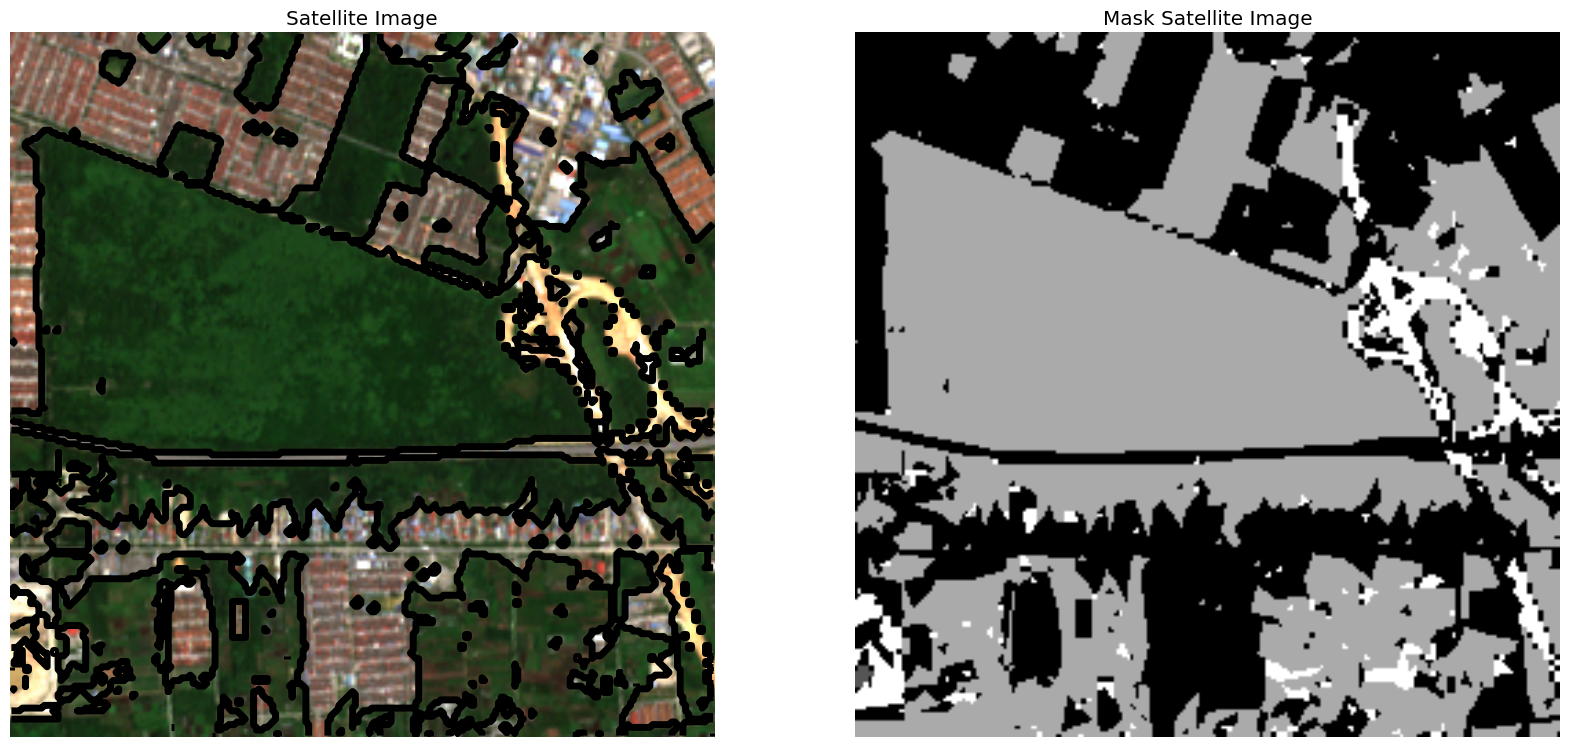

In [106]:
# Visualize any randome image along with the mask
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., :], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellite Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellite Image')
ax2.set_axis_off()

#### 5. Create Baseline Unet Model for Land Cover Prediction
First let's create the Unet architecure

In [54]:

x_in = Input(shape=(256, 256, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(5, (1, 1), activation='softmax', padding='same')(x_temp)

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_44 (Conv2D)             (None, 256, 256, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_32 (Dropout)           (None, 256, 256, 32  0           ['conv2d_44[0][0]']              
                                )                                                           

Train the model based on the Unet architecture we've had created

In [55]:
history = model.fit(X_train, y_train_1hot, validation_data=(X_test, y_test_1hot), epochs=50, batch_size=6, verbose=1)

Epoch 1/50


2024-04-10 12:22:51.627463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29/29 [==============================] - 7s 140ms/step - loss: 1.3906 - accuracy: 0.3549 - val_loss: 1.2555 - val_accuracy: 0.3890
Epoch 2/50
29/29 [==============================] - 4s 123ms/step - loss: 1.0945 - accuracy: 0.5875 - val_loss: 0.9521 - val_accuracy: 0.6705
Epoch 3/50
29/29 [==============================] - 4s 122ms/step - loss: 0.8360 - accuracy: 0.7167 - val_loss: 0.8668 - val_accuracy: 0.7081
Epoch 4/50
29/29 [==============================] - 4s 122ms/step - loss: 0.7652 - accuracy: 0.7250 - val_loss: 0.7252 - val_accuracy: 0.7231
Epoch 5/50
29/29 [==============================] - 4s 122ms/step - loss: 0.6955 - accuracy: 0.7327 - val_loss: 0.7085 - val_accuracy: 0.7198
Epoch 6/50
29/29 [==============================] - 4s 123ms/step - loss: 0.6657 - accuracy: 0.7507 - val_loss: 0.6761 - val_accuracy: 0.7506
Epoch 7/50
29/29 [==============================] - 4s 123ms/step - loss: 0.6119 - accuracy: 0.7960 - val_loss: 0.6588 - val_accuracy: 0.7592
Epoch 8/50
29/29 

Let's see the loss training chart

In [56]:
df_result = pd.DataFrame(history.history)
df_result.sort_values('accuracy', ascending=True, inplace = True)
df_result

,loss,accuracy,val_loss,val_accuracy
0,1.390595,0.354906,1.255472,0.388997
1,1.094486,0.587465,0.952095,0.670504
2,0.835955,0.716683,0.866816,0.708080
3,0.765151,0.724988,0.725176,0.723121
4,0.695477,0.732692,0.708477,0.719770
5,0.665666,0.750668,0.676058,0.750566
27,0.586196,0.783062,0.628397,0.756863
6,0.611902,0.795996,0.658787,0.759212
7,0.580757,0.804631,0.624202,0.765352
12,0.541544,0.805931,0.597130,0.767378


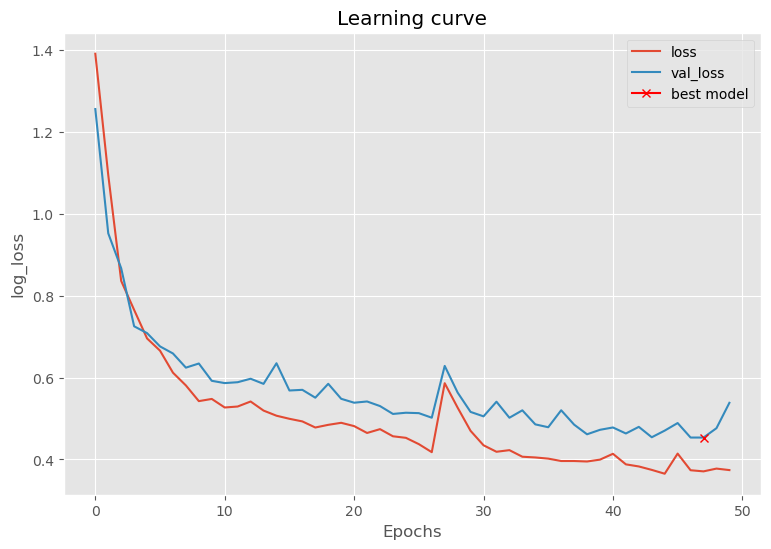

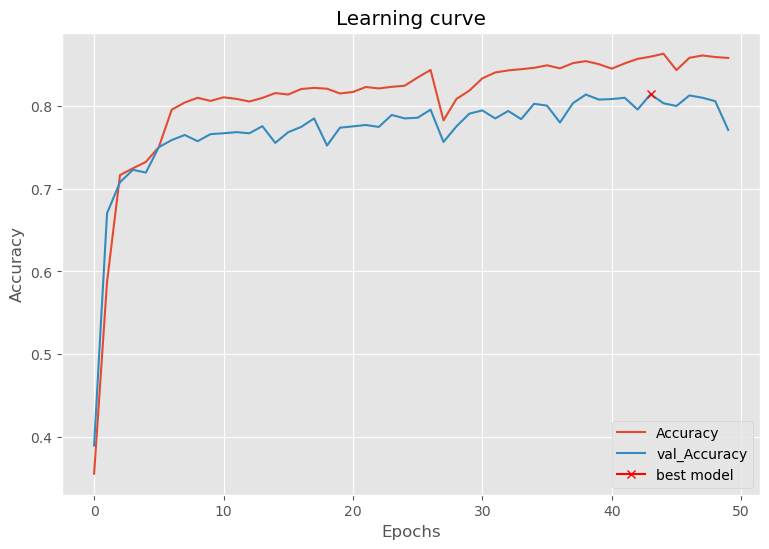

In [57]:
plt.figure(figsize = (9,6))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (9,6))
plt.title("Learning curve")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
     

Let's inference and predict the Unet model into new dataset

In [101]:
'''Prediction over the test dataset'''
pred_test1 = model.predict(X_test)

pred_test1 = np.argmax(pred_test1, axis=-1)
print(pred_test1.shape)


6/6 [==============================] - 1s 156ms/step
(172, 256, 256)


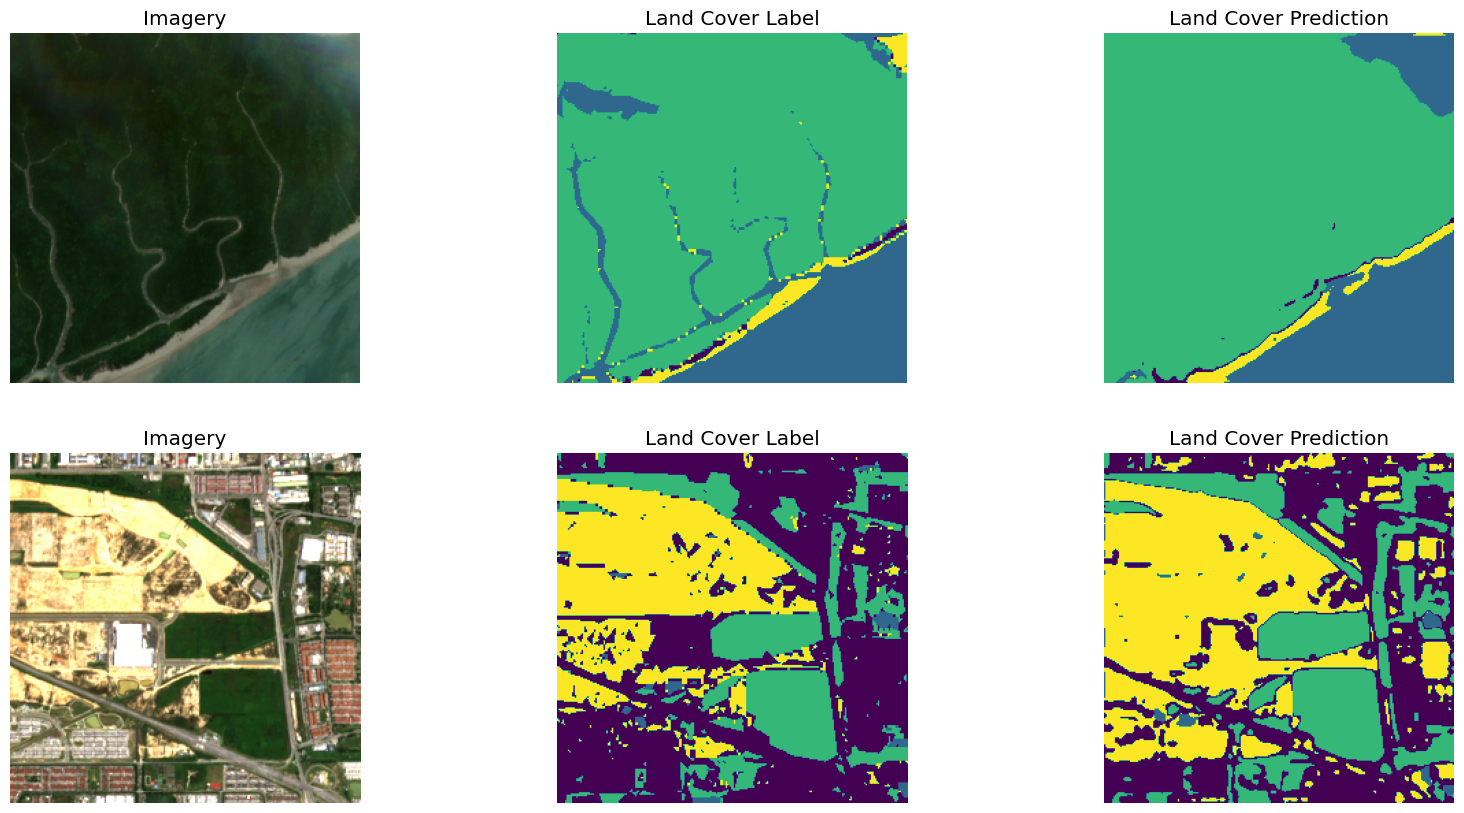

In [102]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

idx1 = 100
idx2 = 20

ax[0][0].imshow(X_test[idx1,:,:,:])
ax[0][0].set_title("Imagery")
ax[0][0].set_axis_off()

ax[0][1].imshow(y_test[idx1, :, :, 0])
ax[0][1].set_title("Land Cover Label")
ax[0][1].set_axis_off()

ax[0][2].imshow(pred_test1[idx1, :, :])
ax[0][2].set_title("Land Cover Prediction")
ax[0][2].set_axis_off()


ax[1][0].imshow(X_test[idx2, :, :,:])
ax[1][0].set_title("Imagery")
ax[1][0].set_axis_off()

ax[1][1].imshow(y_test[idx2, :, :, 0])
ax[1][1].set_title("Land Cover Label")
ax[1][1].set_axis_off()

ax[1][2].imshow(pred_test1[idx2, :, :])
ax[1][2].set_title("Land Cover Prediction")
ax[1][2].set_axis_off()

## 7. Transfer Learning Unet-Resnet34

U-Net with transfer learning using ResNet-34 is a powerful combination for image segmentation tasks. The U-Net architecture, known for its effectiveness in biomedical image segmentation, features a symmetric encoder-decoder structure with skip connections that help preserve spatial information. When combined with ResNet-34, which is pre-trained on large datasets like ImageNet, the model benefits from deep residual learning, allowing it to learn robust feature representations. This transfer learning approach helps in overcoming the challenge of training deep networks from scratch, especially when labeled data is scarce. By utilizing ResNet-34’s learned features, the U-Net model can achieve better generalization and improved segmentation results with fewer epochs of training

Create a Unet model using a transfer learning approach Resnet34

In [69]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [70]:
import tensorflow as tf
import segmentation_models as sm
import glob

import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

from keras.utils import normalize
from keras.metrics import MeanIoU

In [72]:
n_classes = 5
activation = "softmax"

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [80]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [81]:
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes = n_classes, activation=activation)

model1.compile(optim, loss = 'categorical_crossentropy', metrics=metrics)

In [82]:
print(model1.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [83]:
history1=model1.fit(X_train1, 
          y_train_1hot,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_1hot))

Epoch 1/50
22/22 [==============================] - 11s 278ms/step - loss: 1.4793 - iou_score: 0.1073 - f1-score: 0.1570 - val_loss: 1.6499 - val_iou_score: 0.2000 - val_f1-score: 0.2000
Epoch 2/50
22/22 [==============================] - 3s 139ms/step - loss: 1.1496 - iou_score: 0.3850 - f1-score: 0.4744 - val_loss: 1.5505 - val_iou_score: 0.2000 - val_f1-score: 0.2000
Epoch 3/50
22/22 [==============================] - 3s 139ms/step - loss: 0.9626 - iou_score: 0.4759 - f1-score: 0.5691 - val_loss: 1.5153 - val_iou_score: 0.2089 - val_f1-score: 0.2169
Epoch 4/50
22/22 [==============================] - 3s 138ms/step - loss: 0.8451 - iou_score: 0.5271 - f1-score: 0.6133 - val_loss: 1.4991 - val_iou_score: 0.2433 - val_f1-score: 0.2710
Epoch 5/50
22/22 [==============================] - 3s 139ms/step - loss: 0.7824 - iou_score: 0.5416 - f1-score: 0.6228 - val_loss: 1.6007 - val_iou_score: 0.2744 - val_f1-score: 0.3074
Epoch 6/50
22/22 [==============================] - 3s 138ms/step - l

In [84]:
df_result = pd.DataFrame(history1.history)
df_result.sort_values('f1-score', ascending=True, inplace = True)
df_result

,loss,iou_score,f1-score,val_loss,val_iou_score,val_f1-score
0,1.479341,0.107343,0.157012,1.649886,0.200000,0.200000
1,1.149628,0.384984,0.474433,1.550467,0.200000,0.200000
2,0.962572,0.475922,0.569091,1.515290,0.208907,0.216924
3,0.845109,0.527072,0.613312,1.499146,0.243296,0.270983
4,0.782429,0.541620,0.622831,1.600706,0.274362,0.307419
5,0.716009,0.565358,0.645786,1.532529,0.259685,0.291199
6,0.657281,0.598999,0.682502,2.021975,0.283912,0.316999
7,0.619141,0.607274,0.688722,1.688315,0.280044,0.313269
9,0.564086,0.635311,0.725091,1.725631,0.262471,0.298657
8,0.597686,0.639896,0.733531,1.669348,0.266691,0.299395


In [106]:
model1.save('res34_backbone_50epochs.hdf5')

In [93]:
'''Prediction over the test dataset'''
pred_test = model1.predict(X_test)

pred_test = np.argmax(pred_test, axis=-1)
print(pred_test.shape)


6/6 [==============================] - 1s 180ms/step
(172, 256, 256)


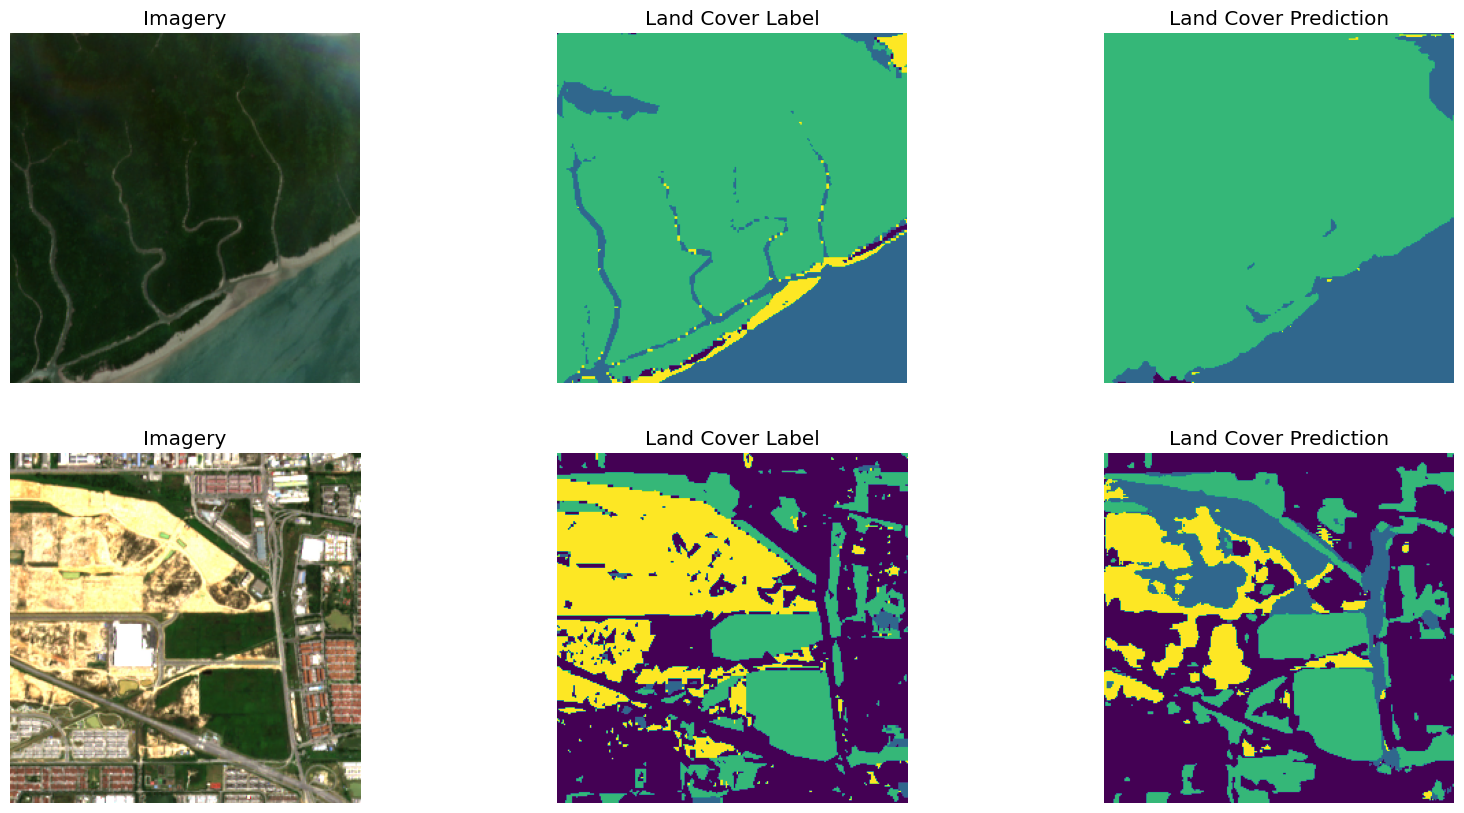

In [92]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

idx1 = 100
idx2 = 20

ax[0][0].imshow(X_test[idx1,:,:,:])
ax[0][0].set_title("Imagery")
ax[0][0].set_axis_off()

ax[0][1].imshow(y_test[idx1, :, :, 0])
ax[0][1].set_title("Land Cover Label")
ax[0][1].set_axis_off()

ax[0][2].imshow(pred_test[idx1, :, :])
ax[0][2].set_title("Land Cover Prediction")
ax[0][2].set_axis_off()


ax[1][0].imshow(X_test[idx2, :, :,:])
ax[1][0].set_title("Imagery")
ax[1][0].set_axis_off()

ax[1][1].imshow(y_test[idx2, :, :, 0])
ax[1][1].set_title("Land Cover Label")
ax[1][1].set_axis_off()

ax[1][2].imshow(pred_test[idx2, :, :])
ax[1][2].set_title("Land Cover Prediction")
ax[1][2].set_axis_off()

## 8. Transfer Learning Unet-VGG16

In the context of U-Net for image segmentation, VGG16 can be used as the encoder part of the network. The idea is to leverage the feature extraction capabilities of VGG16. The architecture of VGG16 is composed of multiple convolution layers followed by max-pooling layers, and fully connected layers at the end.

Create a Unet model using a transfer learning approach VGG16

In [107]:
BACKBONE2 = 'vgg16'
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes = n_classes, activation=activation)

model2.compile(optim, loss = 'categorical_crossentropy', metrics=metrics)


58889256/58889256 [==============================] - 29s 0us/step


In [108]:
print(model2.summary())

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_6[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                         

In [109]:
history1=model2.fit(X_train1, 
          y_train_1hot,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_1hot))

Epoch 1/50
22/22 [==============================] - 14s 431ms/step - loss: 1.0523 - iou_score: 0.2672 - f1-score: 0.3233 - val_loss: 4.4851 - val_iou_score: 0.3082 - val_f1-score: 0.3632
Epoch 2/50
22/22 [==============================] - 5s 235ms/step - loss: 0.7009 - iou_score: 0.4906 - f1-score: 0.5476 - val_loss: 1.4754 - val_iou_score: 0.3562 - val_f1-score: 0.4159
Epoch 3/50
22/22 [==============================] - 5s 234ms/step - loss: 0.6332 - iou_score: 0.5828 - f1-score: 0.6737 - val_loss: 0.8319 - val_iou_score: 0.4850 - val_f1-score: 0.5883
Epoch 4/50
22/22 [==============================] - 5s 234ms/step - loss: 0.6060 - iou_score: 0.5994 - f1-score: 0.6914 - val_loss: 0.7787 - val_iou_score: 0.5248 - val_f1-score: 0.6276
Epoch 5/50
22/22 [==============================] - 5s 235ms/step - loss: 0.5497 - iou_score: 0.6314 - f1-score: 0.7194 - val_loss: 0.7075 - val_iou_score: 0.5827 - val_f1-score: 0.6881
Epoch 6/50
22/22 [==============================] - 5s 235ms/step - l

In [110]:
pred_test3 = model2.predict(X_test)

pred_test3 = np.argmax(pred_test3, axis=-1)
print(pred_test3.shape)


2024-04-10 13:08:36.845517: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


6/6 [==============================] - 7s 683ms/step
(172, 256, 256)


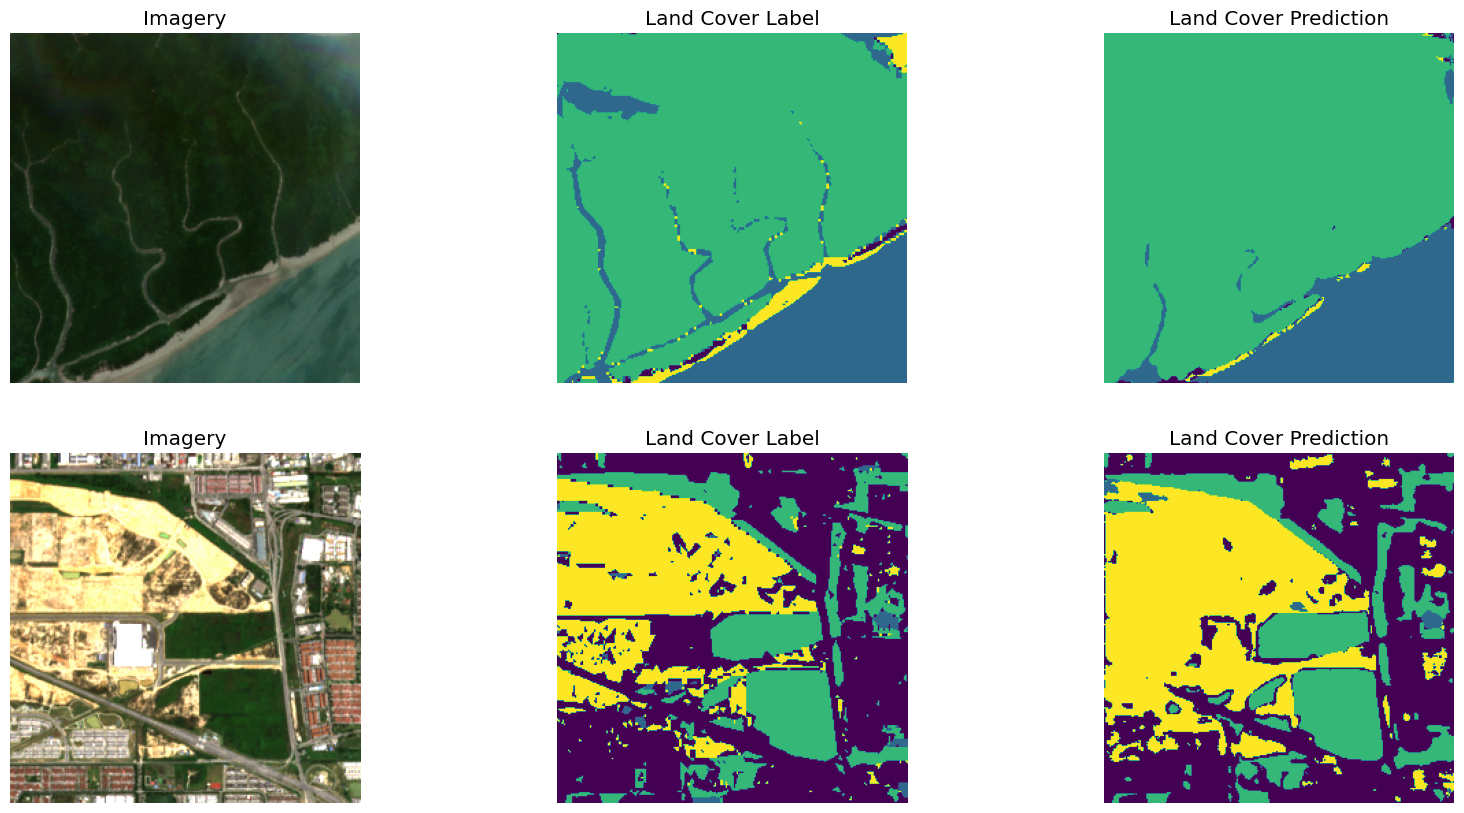

In [111]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

idx1 = 100
idx2 = 20

ax[0][0].imshow(X_test[idx1,:,:,:])
ax[0][0].set_title("Imagery")
ax[0][0].set_axis_off()

ax[0][1].imshow(y_test[idx1, :, :, 0])
ax[0][1].set_title("Land Cover Label")
ax[0][1].set_axis_off()

ax[0][2].imshow(pred_test3[idx1, :, :])
ax[0][2].set_title("Land Cover Prediction")
ax[0][2].set_axis_off()


ax[1][0].imshow(X_test[idx2, :, :,:])
ax[1][0].set_title("Imagery")
ax[1][0].set_axis_off()

ax[1][1].imshow(y_test[idx2, :, :, 0])
ax[1][1].set_title("Land Cover Label")
ax[1][1].set_axis_off()

ax[1][2].imshow(pred_test3[idx2, :, :])
ax[1][2].set_title("Land Cover Prediction")
ax[1][2].set_axis_off()